Fitting a WL mass using `clmm`

_the LSST-DESC CLMM team_

In [1]:
from astropy.cosmology import FlatLambdaCDM
import clmm
from clmm import modeling as mod
from clmm import polaraveraging as avg
import sys
sys.path.append('./support')
import mock_data as mock
from numpy import random
from scipy import optimize as spo

In [2]:
# define a true cosmology
# NB: need to cclify the astropy cosmology for generating the mock data (depends on modeling.py). 
# However, this is the astropy cosmology object that will need to be used on the data side, 
# profileaveraging.py (data side)

mock_cosmo = FlatLambdaCDM(H0=70, Om0=0.27, Ob0=0.045)
# cclify allows access to the cosmo parameter the CCL way, but it is not a CCL cosmology object
mock_cosmo_ccl = mod.cclify_astropy_cosmo(mock_cosmo) 

# Make mock data

In [3]:
# define toy cluster parameters

config = {}
config['cosmo'] = mock_cosmo_ccl
config['cluster_id'] = "Awesome_cluster"
config['cluster_m'] = 1.e15
config['cluster_z'] = 0.3
config['src_z'] = 0.8
config['concentration'] = 4
config['ngals'] = 10000
config['Delta'] = 200

In [4]:
# make mock data object

ideal_data = mock.MockData(config=config)

In [5]:
# populate catalog of galaxy cluster

ideal_data.generate()

In [6]:
# make a clmm.GalaxyCluster object

cluster_ra = 0.0
cluster_dec = 0.0
gc_object = clmm.GalaxyCluster(config['cluster_id'], cluster_ra, cluster_dec, 
                               config['cluster_z'], ideal_data.catalog)

In [7]:
# save the clmm.GalaxyCluster object

gc_object.save('mock_GC.pkl')

# Derive observables

In [8]:
# load a clmm.GalaxyCluster object

cl = clmm.load_cluster('mock_GC.pkl')

ra_l = cl.ra
dec_l = cl.dec
z = cl.z
e1 = cl.galcat['e1']
e2 = cl.galcat['e2']
ra_s = cl.galcat['ra']
dec_s = cl.galcat['dec']

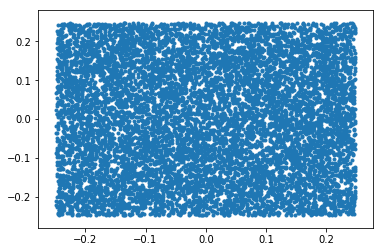

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(ra_s, dec_s, marker='.')

### Tangential shear, cross shear for each source galaxy in the cluster

In [10]:
(theta, g_t, g_x) = avg.compute_shear(cl)

Text(0.5,0,'angular distance [deg?]')

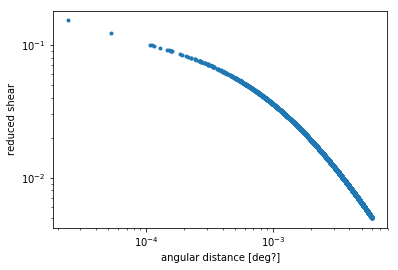

In [11]:
plt.loglog(theta, g_t, '.')
plt.ylabel("reduced shear")
plt.xlabel("angular distance [deg?]")

### Make the binned profile

Using 2 different binning to highlight the impact on the reconstructed mass when doing naive fitting (not accounting for the binning in the model estimation)

In [12]:
# define bins
bin_edges1 = avg.make_bins(0.01, 3.7, 50)
bin_edges2 = avg.make_bins(0.01, 3.7, 10)

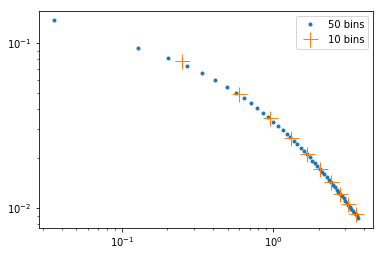

In [13]:
res1 = clmm.polaraveraging.make_shear_profile(cl, "Mpc", 
                                             cosmo=mock_cosmo, 
                                             cosmo_object_type='astropy', bins=bin_edges1)
res2 = clmm.polaraveraging.make_shear_profile(cl, "Mpc", 
                                             cosmo=mock_cosmo, 
                                             cosmo_object_type='astropy', bins=bin_edges2)
plt.loglog(res1['radius'], res1['gt'], '.', label='50 bins')
plt.loglog(res2['radius'], res2['gt'], '+', markersize=15, label='10 bins')
plt.legend()
gt_profile1 = res1['gt']
r1 = res1['radius']

gt_profile2 = res2['gt']
r2 = res2['radius']

# Construct model

Simply estimating the model at the bin location. In that case, the mass reconstruction is dependent on the binning. Future developement would be to take the average of the model inside the bin instead, which should solve this issue for this set of ideal data.

In [17]:
# select density profile parametrization and parameter values
def nfw_to_shear_profile1(logm):
    m = 10.**logm
    gt_model = mod.predict_reduced_tangential_shear(r1, m, config['concentration'], config['cluster_z'], 
                                                    config['src_z'], config['cosmo'], 
                                        Delta=200, halo_profile_parameterization='nfw')
    return sum(gt_model - gt_profile1) **2

def nfw_to_shear_profile2(logm):
    m = 10.**logm
    gt_model = mod.predict_reduced_tangential_shear(r2, m, config['concentration'], config['cluster_z'], 
                                                    config['src_z'], config['cosmo'], 
                                        Delta=200, halo_profile_parameterization='nfw')
    return sum(gt_model - gt_profile2) **2

# Fit for mass

In [18]:
# optimize to find the best-fit mass

logm_0 = random.uniform(13., 17., 1)[0]
logm_est1 = spo.minimize(nfw_to_shear_profile1, logm_0).x
logm_est2 = spo.minimize(nfw_to_shear_profile2, logm_0).x
m_est1 = 10.**logm_est1
m_est2 = 10.**logm_est2

In [19]:
m_est1, m_est2

(array([1.00579684e+15]), array([1.02273852e+15]))

In [29]:
import numpy as np
rr = np.logspace(-2,np.log10(5),100)
gt_model1 = mod.predict_reduced_tangential_shear(rr, m_est1, config['concentration'], config['cluster_z'], 
                                                    config['src_z'], config['cosmo'], 
                                        Delta=200, halo_profile_parameterization='nfw')

gt_model2 = mod.predict_reduced_tangential_shear(rr, m_est2, config['concentration'], config['cluster_z'], 
                                                    config['src_z'], config['cosmo'], 
                                        Delta=200, halo_profile_parameterization='nfw')

Text(0,0.5,'reduced tangential shear')

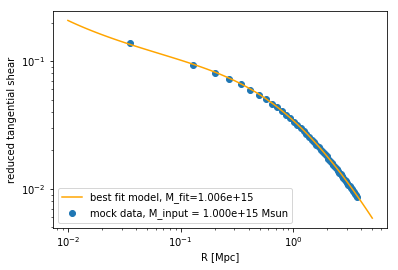

In [30]:
plt.scatter(r1, gt_profile1, label='mock data, M_input = %.3e Msun'%config['cluster_m'])
plt.plot(rr, gt_model, label = 'best fit model, M_fit=%.3e'%m_est1, color='orange')
plt.semilogx()
plt.semilogy()

plt.legend()
plt.xlabel('R [Mpc]')
plt.ylabel('reduced tangential shear')

Text(0,0.5,'reduced tangential shear')

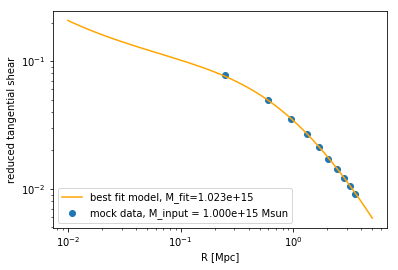

In [31]:
plt.scatter(r2, gt_profile2, label='mock data, M_input = %.3e Msun'%config['cluster_m'])
plt.plot(rr, gt_model, label = 'best fit model, M_fit=%.3e'%m_est2, color='orange')
plt.semilogx()
plt.semilogy()

plt.legend()
plt.xlabel('R [Mpc]')
plt.ylabel('reduced tangential shear')